In [1]:
print("hello world")

hello world


In [1]:
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from functions import  extract_features
from filters import butter_filter_lowpass
from functions import rf_fit
from functions import process_sliding_window

%matplotlib notebook



0.7269655172413791


In [2]:

def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            intout = (np.bitwise_and(data_in[i], 127)) * 128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result, intout)
        i = i + 1
    return np.array(result)

In [3]:
#Reads the ports from device
from serial.tools import list_ports
port = list(list_ports.comports())
for p in port:
    print(p.device)

/dev/cu.Bluetooth-Incoming-Port
/dev/cu.usbserial-DJ00E2W2


In [4]:
# Read example data
baudrate = 230400
cport = '/dev/cu.usbserial-DJ00E2W2'  # set the correct port before you run it
#cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
ser = serial.Serial(port=cport, baudrate=baudrate)    
# take example data
inputBufferSize = 10000 # 20000 = 1 second
ser.timeout = inputBufferSize/10000.0  # set read timeout
#ser.set_buffer_size(rx_size = inputBufferSize)

In [5]:

data = read_arduino(ser,inputBufferSize)
data = butter_filter_lowpass(data)
data_plot = process_data(data)
plt.figure()
plt.plot(data_plot)
plt.show()

<IPython.core.display.Javascript object>

In [7]:
# Define the sliding window size
total_time = 20.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
window_size = 10000
N_loops = 20000.0/inputBufferSize*total_time

# Initialize an empty buffer to store the data
data_buffer = np.array([])

# Initialize the figure for plotting
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

# Start the streaming loop
for k in range(int(N_loops)):
    # Read the data from the Arduino
    data = read_arduino(ser, inputBufferSize)
    data_temp = process_data(data)
    
    # Append the new data to the buffer
    data_buffer = np.append(data_buffer, data_temp)
    
    # Process the sliding window of data if it's larger than the window size
    if len(data_buffer) >= window_size:
        # Extract the sliding window of data
        window_data = data_buffer[-window_size:]
        
        # Process the sliding window and make predictions
        predictions = process_sliding_window(window_data)
        
        print(predictions)
        
        # Update the buffer by removing the processed data
        data_buffer = data_buffer[:-inputBufferSize]
    
    # Plot the data
    t = np.linspace(0, len(data_buffer) / 20000.0, len(data_buffer))
    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t, data_buffer)
    fig.canvas.draw()
    plt.show()


<IPython.core.display.Javascript object>

['L']
['L']
['L']
['R']
['B']
['R']
['R']
['R']
['B']
['B']
['L']
['R']
['L']
['L']
['L']
['L']
['L']
['L']
['R']


 mark classifier

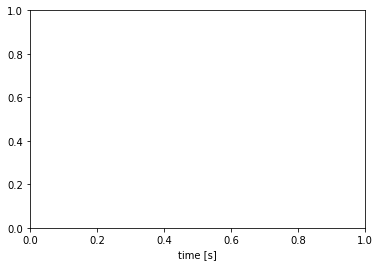

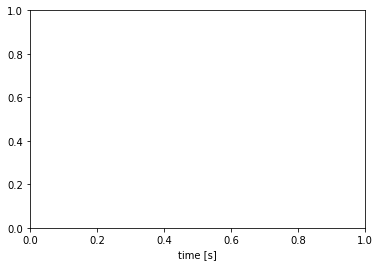

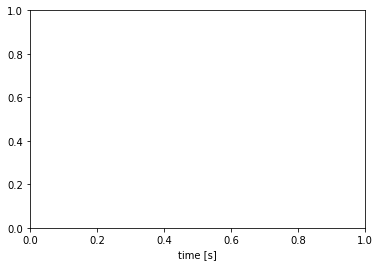

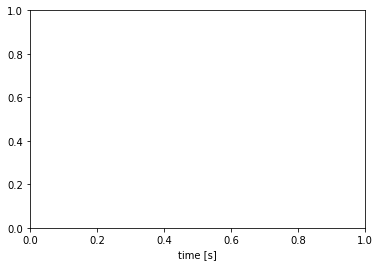

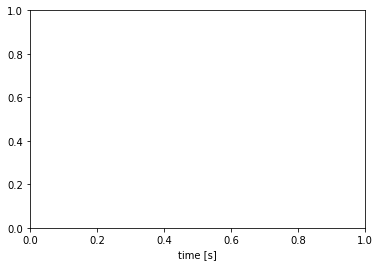

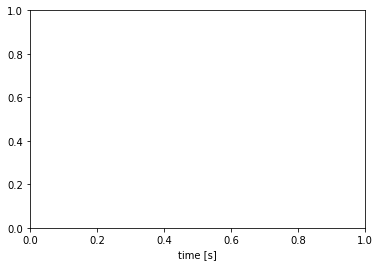

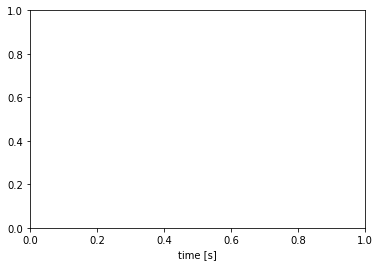

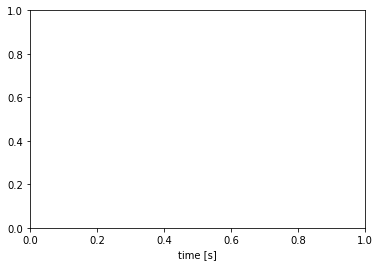

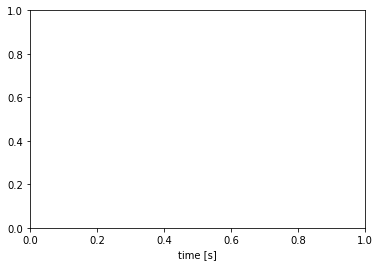

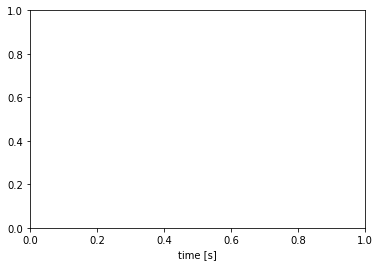

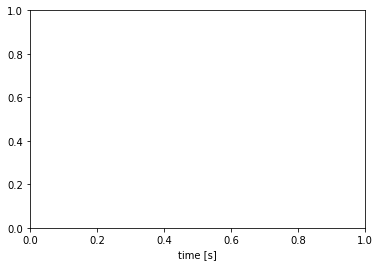

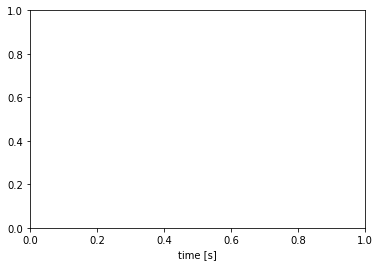

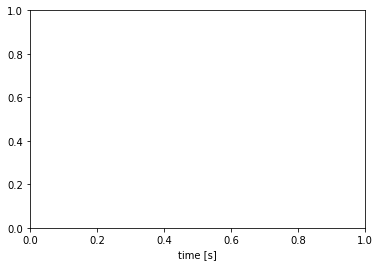

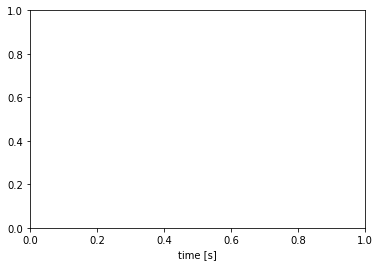

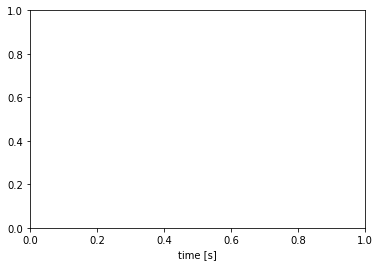

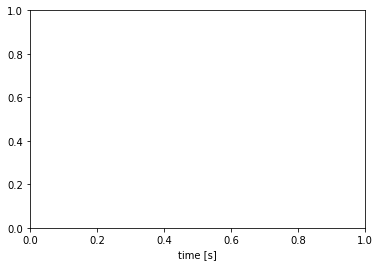

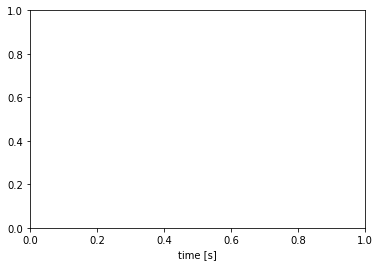

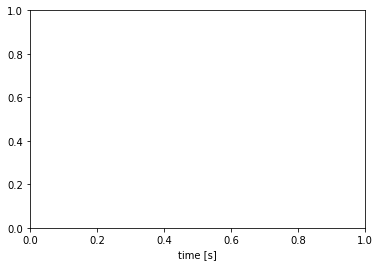

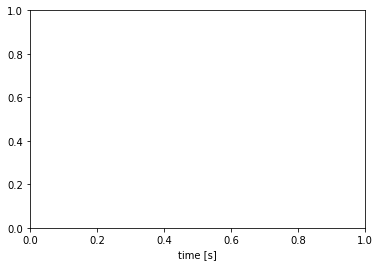

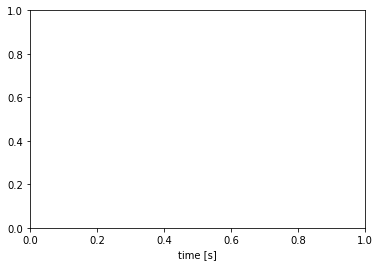

KeyboardInterrupt: 

In [15]:
from event_classifier import *

for k in range(0, int(N_loops)):
    data = read_arduino(ser, inputBufferSize)
    data_temp = process_data(data)
    
    if k <= N_max_loops:
        if k == 0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp, data_plot)
        t = (min(k+1, N_max_loops)) * inputBufferSize / 20000.0 * np.linspace(0, 1, len(data_plot))
    else:
        data_plot = np.roll(data_plot, len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
    t = (min(k+1, N_max_loops)) * inputBufferSize / 20000.0 * np.linspace(0, 1, len(data_plot))

    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t, data_plot)
    fig.canvas.draw()
    plt.show()
    
    # Perform event prediction
    predicted_labels, prev_sd, is_peak_found = predict_events(data_temp, 10, "yes")